In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER


In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14, 24)
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 14, 24)

In [6]:
t_all.shape

(52, 7, 14, 24)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Conv1D, Dense, Flatten, MaxPool1D, InputLayer, Activation, Dropout, MaxPooling1D


import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

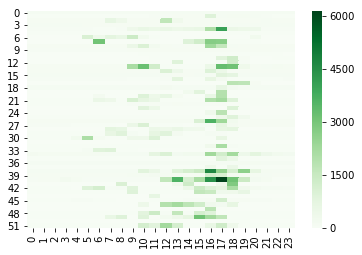

In [180]:
sns.heatmap(t_all[:, 6, :, :].sum(axis=1),cmap='Greens')

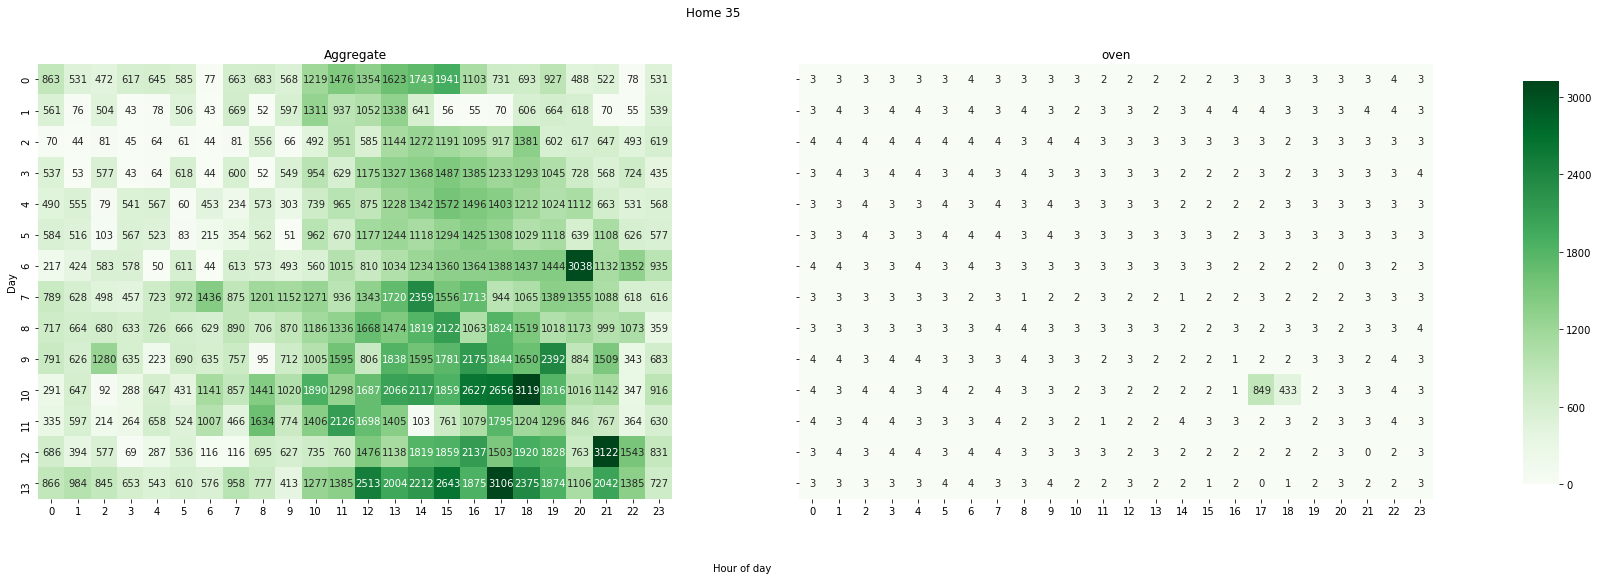

In [187]:
import seaborn as sns
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(25,8))
cbar_ax = fig.add_axes([.95, 0.15, .02, .7])
home = 35
appliance_num = 6
sns.heatmap(t_all[home, 0, :, :],cmap='Greens',ax=ax[0],cbar_ax=None,cbar=False,annot=True, fmt='.0f')
sns.heatmap(t_all[home, appliance_num, :, :],cmap='Greens',ax=ax[1],cbar_ax=cbar_ax,vmax=t_all[home, 0, :, :].max(),annot=True, fmt='.0f')
ax[0].set_title("Aggregate")
ax[1].set_title(APPLIANCES_ORDER[appliance_num])
ax[0].set_ylabel("Day")
fig.text(0.5, 0, "Hour of day")
plt.suptitle("Home {}".format(home))
plt.savefig("/Users/nipun/Desktop/home_{}_oven.png".format(home))


In [11]:
num_days = 14
num_hours = 24

In [123]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Merge, Reshape
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(num_days, num_hours, 1))  # adapt this if using `channels_first` image data format

x = Flatten()(Conv2D(20, (1, 2), activation='relu', padding='same',name='Conv')(input_img))
y = Flatten()(Conv2D(20, (2, 1), activation='relu', padding='same')(input_img))


#x = MaxPooling2D((1, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
#x = UpSampling2D((1, 2))(x)
z = Dense(units=14*24)(Merge(mode='concat')([x, y]))
z = Reshape((14, 24,1))(z)
autoencoder = Model(input_img, z)
from keras.optimizers import Adam


/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [124]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 14, 24, 1)    0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 14, 24, 20)   60          input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 24, 20)   60          input_11[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 6720)         0           Conv[0][0]                       
__________________________________________________________________________________________________
flatten_6 

In [125]:
appliance_num=1
print(APPLIANCES_ORDER[appliance_num])

hvac


In [126]:
maxs = {appliance_num:t_all[:30, appliance_num, :, :].max() for appliance_num in range(7)}

In [127]:
maxs

{0: 5000.416633605957,
 1: 3963.88330078125,
 2: 288.85000610351562,
 3: 960.7833251953125,
 4: 1122.300048828125,
 5: 498.43331909179688,
 6: 2914.800048828125}

In [128]:
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.fit((t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[0])
                ,validation_split=0.1,epochs=1500)
#autoencoder.fit((t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[0])
#                ,validation_split=0.1,epochs=1000)

Train on 27 samples, validate on 3 samples
Epoch 1/1500
27/27 [==============================] - 1s 24ms/step - loss: 0.1818 - val_loss: 0.1841
Epoch 2/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.1526 - val_loss: 0.1765
Epoch 3/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.1476 - val_loss: 0.1402
Epoch 4/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.1107 - val_loss: 0.1326
Epoch 5/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.1279
Epoch 6/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.1068 - val_loss: 0.1156
Epoch 7/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0885 - val_loss: 0.1170
Epoch 8/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.1277
Epoch 9/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.1287
Epoch 10/1500
27/27 [==============================] - 0

Epoch 82/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.1015
Epoch 83/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.1010
Epoch 84/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.1010
Epoch 85/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.1012
Epoch 86/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.1019
Epoch 87/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.1019
Epoch 88/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.1019
Epoch 89/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.1014
Epoch 90/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.1008
Epoch 91/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0102 - val_los

Epoch 163/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.1039
Epoch 164/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.1049
Epoch 165/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.1051
Epoch 166/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.1048
Epoch 167/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.1043
Epoch 168/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.1041
Epoch 169/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.1046
Epoch 170/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.1050
Epoch 171/1500
27/27 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.1047
Epoch 172/1500
27/27 [==============================] - 0s 3ms/step - loss: 0.0069

KeyboardInterrupt: 

In [129]:
pred = maxs[0]*autoencoder.predict(t_all[30:, appliance_num, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

380.36358493780546

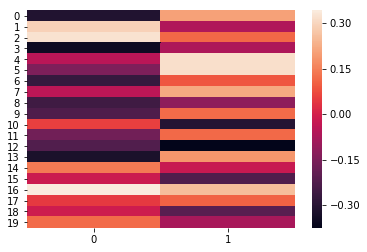

In [131]:
sns.heatmap(autoencoder.get_layer("Conv").get_weights()[0].reshape(20,2))

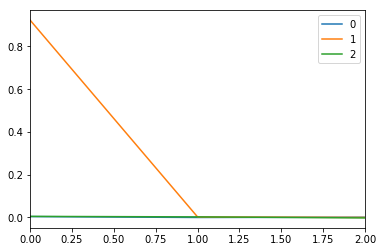

In [99]:
pd.DataFrame(autoencoder.get_layer("Conv").get_weights()[0].reshape(3,3)).T.plot()

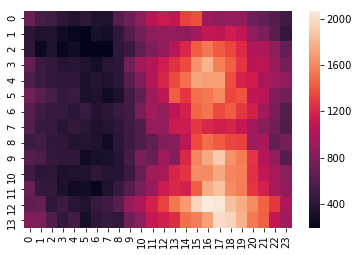

In [39]:
sns.heatmap(t_all[:30, appliance_num, :, :].mean(axis=0))

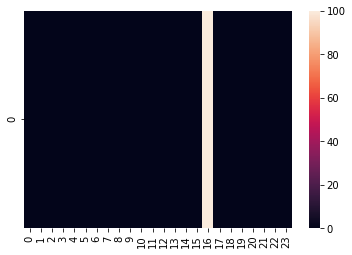

In [85]:
sns.heatmap(f)

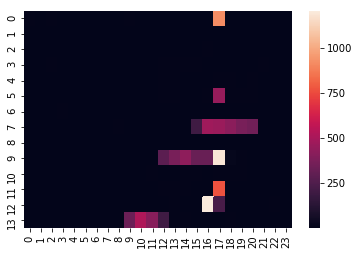

In [87]:
sns.heatmap(t_all[4, appliance_num, :, :])

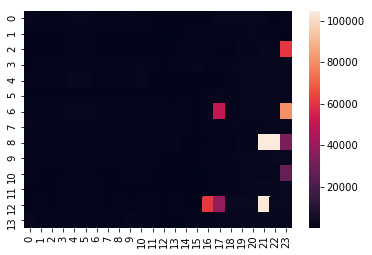

In [81]:
appliance_num=6
f = np.zeros((1,24))
f[:,16]
sns.heatmap(convolve2d(t_all[34, appliance_num, :, :], f, mode='same',boundary='symmetric'))

In [76]:
autoencoder.get_layer("Conv").get_weights()[1]

array([-0.08530973], dtype=float32)

In [71]:
from scipy.signal import convolve2d
sns.heatmap(convolve2d(t_all[34, appliance_num, :, :], autoencoder.get_layer("Conv").get_weights()[0].reshape(1,24),mode='same'),vmax=maxs[appliance_num])

ValueError: cannot reshape array of size 288 into shape (1,24)

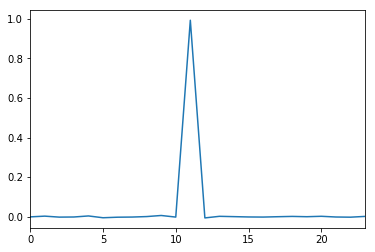

In [25]:
pd.Series(autoencoder.get_layer("Conv").get_weights()[0].flatten()).plot()

In [79]:
plt.plot(autoencoder.get_weights()[2].reshape(1,24).T)

IndexError: list index out of range

In [80]:
pd.DataFrame(5000*((t_all[30, 0, :, :].reshape(num_days, num_hours)/maxs[0])*autoencoder.get_weights()[0].reshape((14, 1))))

ValueError: cannot reshape array of size 24 into shape (14,1)

In [81]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [82]:
sns.heatmap(signal.convolve2d(t_all[2, 6, :, :], np.array([[1,-1]]), mode='same'),cmap='Greens')

NameError: name 'signal' is not defined

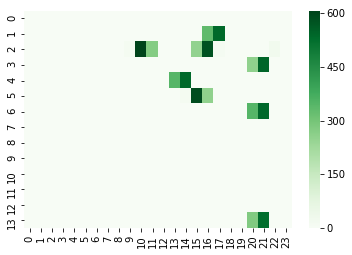

In [83]:
sns.heatmap(t_all[2, 4, :, :],cmap='Greens')

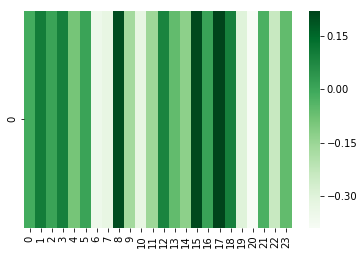

In [84]:
sns.heatmap(autoencoder.get_weights()[0].reshape(1,24),cmap='Greens')

In [85]:
def activate(x):
    
    x[x<0.] = 0
    return x

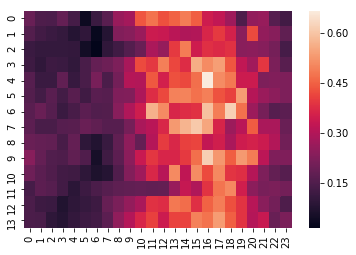

In [86]:
sns.heatmap(t_all[1, 0, :, :].reshape(num_days, num_hours)/maxs[0])

In [87]:
from scipy import signal


In [88]:
c = autoencoder.get_weights()[0].reshape(14,1)
b_c = autoencoder.get_weights()[1].flatten()
d = autoencoder.get_weights()[0].reshape(14,1)
b_d =  autoencoder.get_weights()[3].flatten()
x = t_all[3, 0, :, :].reshape(num_days, num_hours)/maxs[0]
c_x = signal.convolve2d(x, c, boundary='symm', mode='same') + b_c

d_c_x = signal.convolve2d(c_x, d, boundary='symm', mode='same') + b_d

ValueError: cannot reshape array of size 24 into shape (14,1)

In [89]:
plt.plot(c)

NameError: name 'c' is not defined

In [90]:
plt.plot(maxs[0]*d_c_x[0])
plt.plot((t_all[3, 6, :, :].reshape(num_days, num_hours)[0]))

NameError: name 'd_c_x' is not defined

In [91]:
x = ((t_all[3, 0, :, :].reshape(num_days, num_hours)/maxs[0])*autoencoder.get_weights()[0].reshape(14,1)) + autoencoder.get_weights()[1]
x1 = activate(x)
sns.heatmap(x1)
x2 = activate(x1*autoencoder.get_weights()[2].reshape(14,1) +  autoencoder.get_weights()[3].flatten())
plt.figure()
sns.heatmap(x2)

ValueError: cannot reshape array of size 24 into shape (14,1)

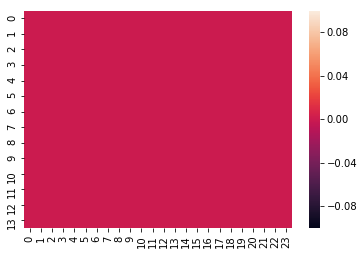

In [92]:
sns.heatmap(pd.DataFrame(maxs[0]*autoencoder.predict(t_all[32:33, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(num_days, num_hours)))

In [93]:
x2*5000.

NameError: name 'x2' is not defined

In [95]:
pred.shape, (t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).shape

((22, 14, 24), (30, 14, 24, 1))

19.741985995572936

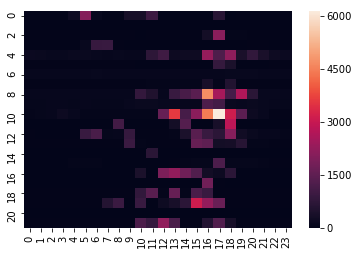

In [68]:
sns.heatmap(pred.sum(axis=1))

In [42]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

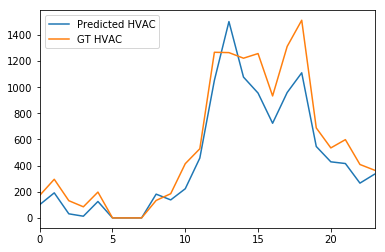

In [43]:
pred_overall_appliance = (maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0])).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
#pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-cnn.png")

In [ ]:
pred_overall_appliance = (maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0])).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-dw-cnn.png")

In [ ]:
plt.plot(autoencoder.layers[2].get_weights()[0].flatten())

In [ ]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [ ]:
train_hvac.shape

In [ ]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

In [ ]:
#pred_appliance = {}
sequence_length=24
num_iterations_dictionary = {'hvac':400,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[2:]:


    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    model = Sequential()
    filters=20
    kernel_size=2
    model.add(InputLayer(input_shape=(sequence_length,1)))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=1 ,name='C1'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))
    model.add(Conv1D(filters=20,
                     kernel_size=5,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=25,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=30,
                     kernel_size=2,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(sequence_length, activation='relu'))
    model.add(Dropout(rate=0.1))


    model.compile('adam','mean_absolute_error')
    model.fit(train_agg.reshape(-1, 24, 1), train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg.reshape(-1,24,1))



In [ ]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [ ]:
model.summary()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [ ]:
pd.Series(mae)

In [ ]:
pd.Series(mae)

In [ ]:
plt.imshow(test_agg.T)

In [ ]:
import seaborn as sns
sns.heatmap(test_appliance['dw'].T)

In [ ]:
pd.Series(test_appliance['hvac'][14]).plot(label='GT')

pd.Series(pred_appliance['hvac'][14]).plot(label='Pred')
plt.legend()

In [ ]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




In [ ]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

In [ ]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()